In [40]:
import os
from pathlib import Path
import pandas as pd

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# outflank

"This is particularly problematic when the average level of differentiation is high, because even with selective neutrality, the variance in FST values among loci increases with average FST, which makes detection of outlier loci difficult for highly differentiated populations (fig. 1)."

https://www.journals.uchicago.edu/doi/full/10.1086/688018

In [2]:
proj_dir="/master/nplatt/sch_man_nwinvasion"
results_dir="{}/results".format(proj_dir)

In [3]:
os.chdir(proj_dir)
if not os.path.isdir("{}/outflank".format(results_dir)):
    os.mkdir("{}/ld".format(results_dir))
    
os.chdir("{}/outflank".format(results_dir))

In [6]:
%%bash 

#remove the samples we aren't interested in
vcf-query -l ../phasing/auto_beagle.vcf \
    | grep -v rep \
    | grep -e Sm.BR -e Sm.SN -e Sm.NE \
    >ingroup_samples.list


vcftools \
    --vcf ../phasing/auto_beagle.vcf \
    --keep ingroup_samples.list \
    --maf 0.05 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >auto_beagle_maf05_ingroups.vcf
 
#go ahead and ld filter the snot of out the file as well
plink \
    --vcf auto_beagle_maf05_ingroups.vcf \
    --allow-extra-chr \
    --double-id \
    --indep-pairwise 1000 5 0.20 \
    --out ld_pruned

# vcftools \
#     --vcf auto_beagle_maf05_ingroups.vcf \
#     --exclude auto_beagle_maf05_ingroups_ld_filtered.prune.out \
#     --recode \
#     --recode-INFO-all \
#     --stdout \
#     --thin 10000 \
#     >auto_beagle_maf05_ingroups_ld_filtered.vcf



PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ld_pruned.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 1000 5 0.20
  --out ld_pruned
  --vcf auto_beagle_maf05_ingroups.vcf

128540 MB RAM detected; reserving 64270 MB for main workspace.
--vcf: ld_pruned-temporary.bed + ld_pruned-temporary.bim +
ld_pruned-temporary.fam written.
21913 variants loaded from .bim file.
80 people (0 males, 0 females, 80 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ld_pruned.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 80 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
21913 variants and 80 peopl


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../phasing/auto_beagle.vcf
	--keep ingroup_samples.list
	--recode-INFO-all
	--maf 0.05
	--recode
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 80 out of 155 Individuals
Outputting VCF file...
After filtering, kept 21913 out of a possible 475081 Sites
Run Time = 10.00 seconds


In [7]:
%%R 

#install.packages('vcfR', repos='http://cran.us.r-project.org')
library("vcfR")
library("qvalue")
library("dartR")
library("devtools")
library("adegenet")

#devtools::install_github("whitlock/OutFLANK")
library("OutFLANK")

In [16]:
%%R

#read in vcf
vcfr <- read.vcfR("auto_beagle_maf05_ingroups.vcf")

# Convert to genind object
genind = vcfR2genind(vcfr)

# Add site IDs to genind object
genind$pop = as.factor(substr(indNames(genind), 4, 5))

# #make locus names
pos <- getPOS(vcfr)
chr <- getCHROM(vcfr)
locus_names<-paste(chr, pos, sep=":")

Scanning file to determine attributes.
File attributes:
  meta lines: 9
  header_line: 10
  variant count: 21913
  column count: 89
Meta line 9 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 21913
  Character matrix gt cols: 89
  skip: 0
  nrows: 21913
  row_num: 0
Processed variant: 0002000300040005000600070008000900010000110001200013000140001500016000170001800019000200002100021913
All variants processed


Calculating FSTs, may take a few minutes...
[1] "10000 done of 43826"
[1] "20000 done of 43826"
[1] "30000 done of 43826"
[1] "40000 done of 43826"


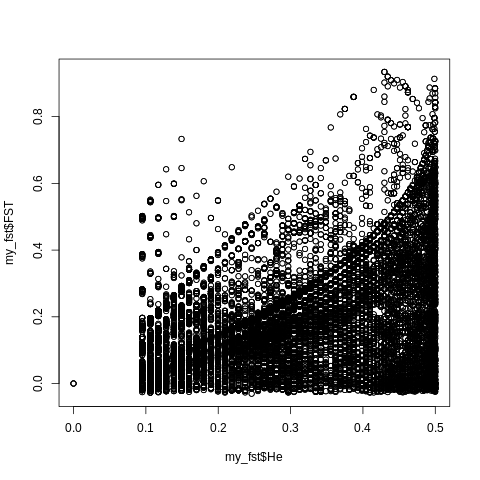

In [17]:
%%R

my_fst <- MakeDiploidFSTMat(genind$tab, locusNames=genind$all.names, popNames = genind$pop)
#png(filename = "he_vs_fst.png");
my_fst$LocusNames<-locus_names
plot(my_fst$He, my_fst$FST)
#dev.off();

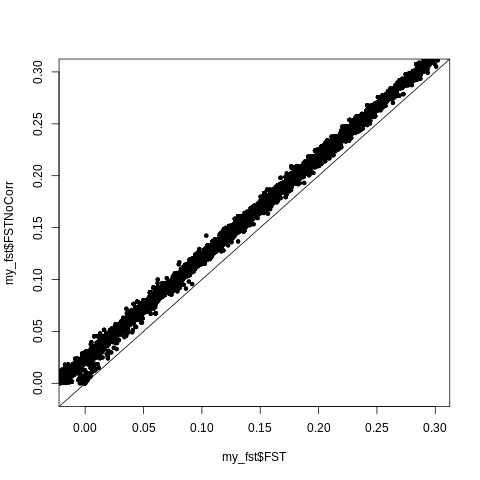

In [18]:
%%R

#png(filename = "fst_vs_fstnocor.png");
plot(my_fst$FST, my_fst$FSTNoCorr,     xlim=c(-0.01,0.3), ylim=c(-0.01,0.3),
     pch=20)
abline(0,1)
#dev.off();

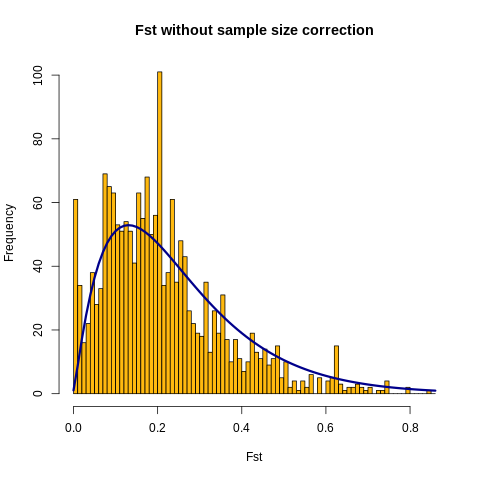

In [20]:
%%R

unlinked_ids<-read.csv("ld_pruned.prune.in")

neutral_idxs<-c()
for (locus_name in unlinked_ids) {
    idx <- match(locus_name,locus_names)
    neutral_idxs <- append(neutral_idxs, idx)
}

out_trim <- OutFLANK(my_fst[neutral_idxs,], NumberOfSamples=3, qthreshold = 0.05, Hmin = 0.1, LeftTrimFraction=0.05, RightTrimFraction=0.05)


#png(filename = "neutral_fst.png");
OutFLANKResultsPlotter(out_trim, 
                       withOutliers = TRUE,
                       NoCorr = TRUE, 
                       Hmin = 0.1, 
                       binwidth = 0.01, 
                       Zoom = FALSE, 
                       RightZoomFraction = 0.05, 
                       titletext = NULL)

#dev.off()

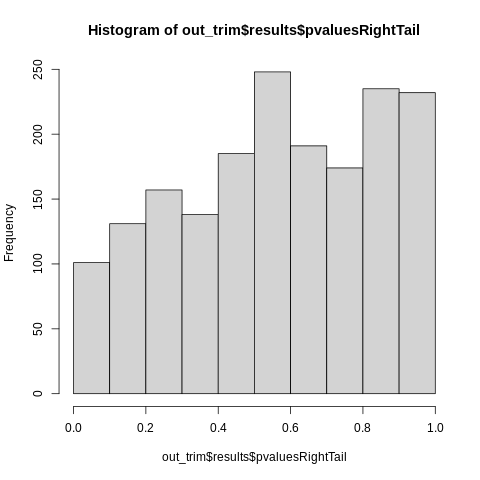

In [21]:
%%R

hist(out_trim$results$pvaluesRightTail)

In [22]:
%%R

P1 <- pOutlierFinderChiSqNoCorr(my_fst, 
                                Fstbar = out_trim$FSTNoCorrbar, 
                                dfInferred = out_trim$dfInferred, 
                                qthreshold = 0.05, 
                                Hmin=0.1)

In [23]:
%%R
out_trim$FSTNoCorrbar

[1] 0.2509157


In [24]:
%%R
#head(P1)

which(P1$OutlierFlag == TRUE)

integer(0)


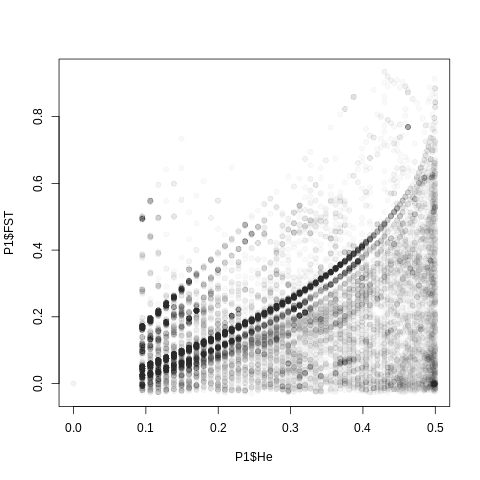

In [25]:
%%R

my_out <- P1$OutlierFlag==TRUE
plot(P1$He, P1$FST, pch=19, col=rgb(0,0,0,0.01))
points(P1$He[my_out], P1$FST[my_out], col="blue")

# Pcadapt

https://bcm-uga.github.io/pcadapt/articles/pcadapt.html


In [27]:
%%bash

plink \
    --vcf auto_beagle_maf05_ingroups.vcf \
    --allow-extra-chr \
    --double-id \
    --make-bed \
    --out nw_se_ne_auto_beagle_maf05



PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to nw_se_ne_auto_beagle_maf05.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --make-bed
  --out nw_se_ne_auto_beagle_maf05
  --vcf auto_beagle_maf05_ingroups.vcf

128540 MB RAM detected; reserving 64270 MB for main workspace.
--vcf: nw_se_ne_auto_beagle_maf05-temporary.bed +
nw_se_ne_auto_beagle_maf05-temporary.bim +
nw_se_ne_auto_beagle_maf05-temporary.fam written.
21913 variants loaded from .bim file.
80 people (0 males, 0 females, 80 ambiguous) loaded from .fam.
Ambiguous sex IDs written to nw_se_ne_auto_beagle_maf05.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 80 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737

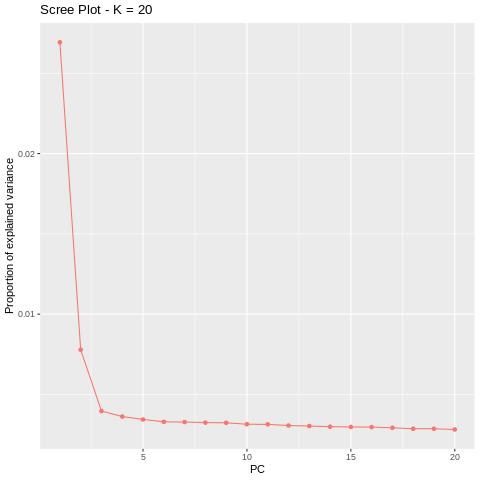

In [28]:
%%R

#install.packages("pcadapt")
library(pcadapt)


path_to_file <- "nw_se_ne_auto_beagle_maf05.bed"
plink_file <- read.pcadapt(path_to_file, type = "bed")

x <- pcadapt(input = plink_file, K = 20, LD.clumping = list(size = 100, thr = 0.2))

#png(filename = "screeplot.png");
plot(x, option = "screeplot")
#dev.off()

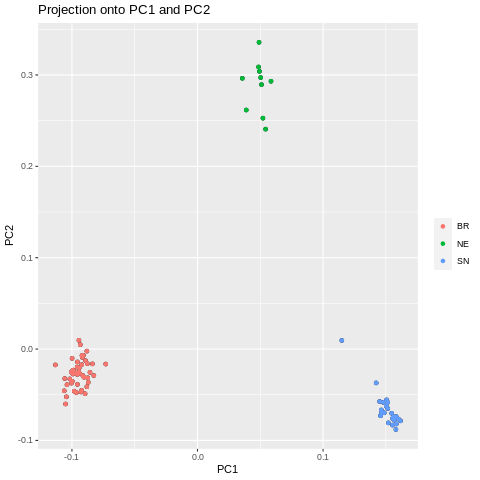

In [29]:
%%R

# With integers
pop_list<-as.factor(substr(indNames(genind), 4, 5))


#png(filename = "pcadapt_scores_pc1-2.png")
plot(x, option = "scores", pop = pop_list)
#dev.off()

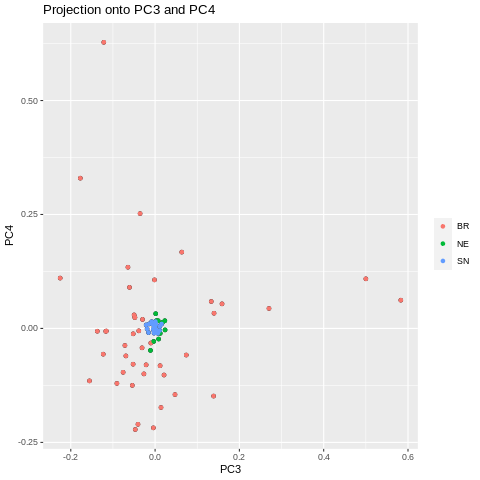

In [30]:
%%R

#png(filename = "pcadapt_scores_pc3-4.png")
plot(x, option = "scores", i = 3, j = 4, pop = pop_list)
#dev.off()

[1] 442


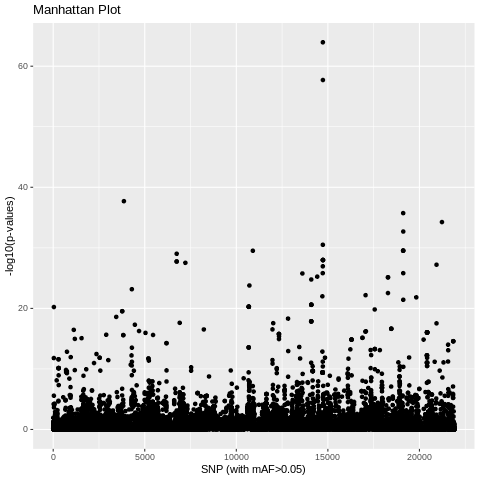

In [31]:
%%R

x <- pcadapt(input = plink_file, K = 2, LD.clumping = list(size = 100, thr = 0.2))

#summary(x)

#png(filename = "pcadapt_manhattan_k2.png")
plot(x , option = "manhattan")
#dev.off()

padj <- p.adjust(x$pvalues,method="bonferroni")
alpha <- 0.05
outliers <- which(padj < alpha)
length(outliers)

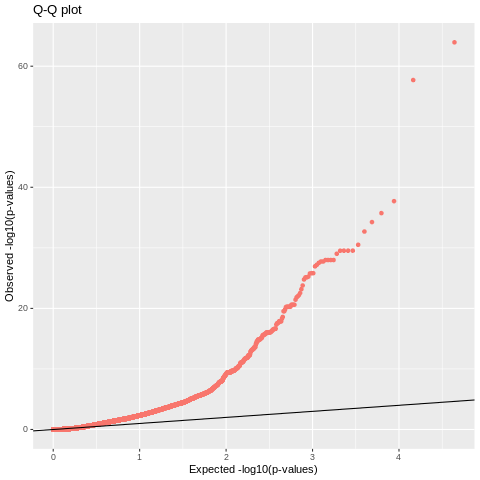

In [32]:
%%R

#png(filename = "pcadapt_qq_k2.png")
plot(x, option = "qqplot")
#dev.off()

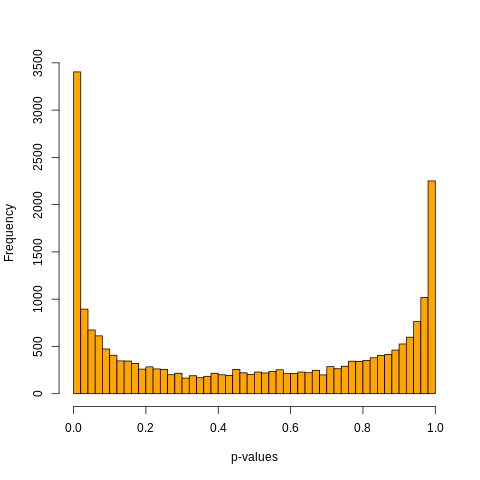

In [33]:
%%R

#png(filename = "pcadapt_pvalues_k2.png")
hist(x$pvalues, xlab = "p-values", main = NULL, breaks = 50, col = "orange")
#dev.off()

In [34]:
%%R

#bonferonni correction
padj <- p.adjust(x$pvalues,method="bonferroni")
alpha <- 0.05
outliers <- which(padj < alpha)
length(outliers)

[1] 442


In [35]:
%%R

#table with
#pos, chrom, chi2, pvalues, corrected-p, -log10pvalue, component, outlier(T/F)
pos <- getPOS(vcfr)
chrom <- getCHROM(vcfr)
stat <- x$stat
chi2 <- x$chi2.stat
pval <- x$pvalues
padj <- padj
logp <- -log10(padj)
sigs<-c(rep("FALSE", length(padj)))
for (idx in outliers) {
    sigs[idx]="TRUE"
}

comps<-c(rep("NaN", length(padj)))

snp_pc<-get.pc(x, outliers)

for (idx in snp_pc$SNP) {
    comps[idx]=snp_pc$PC[snp_pc$SNP==idx]
}

het<-my_fst$He[c(TRUE, FALSE)]
fst<-my_fst$FSTNoCorr[c(TRUE, FALSE)]

df=data.frame(chrom, pos, stat, chi2, pval, padj, logp, sigs, comps, fst, het, stringsAsFactors=TRUE)
write.csv(df,"pcadapt.csv", row.names = FALSE, quote=FALSE)
head(df, 20)


     chrom     pos       stat      chi2       pval padj logp  sigs comps
1  SM_V7_1  302288  1.7071525 0.9438588 0.62379755    1    0 FALSE   NaN
2  SM_V7_1  705322  1.3286242 0.7345762 0.69261006    1    0 FALSE   NaN
3  SM_V7_1  705340  2.0497358 1.1332679 0.56743222    1    0 FALSE   NaN
4  SM_V7_1 1060362  0.9230204 0.5103240 0.77479096    1    0 FALSE   NaN
5  SM_V7_1 1060390 16.2750582 8.9982336 0.01111881    1    0 FALSE   NaN
6  SM_V7_1 1197094  4.4147546 2.4408511 0.29510456    1    0 FALSE   NaN
7  SM_V7_1 1197521  7.7140729 4.2649943 0.11854091    1    0 FALSE   NaN
8  SM_V7_1 1197568  7.7140729 4.2649943 0.11854091    1    0 FALSE   NaN
9  SM_V7_1 1197961 10.3655249 5.7309420 0.05695630    1    0 FALSE   NaN
10 SM_V7_1 1198172  9.8798071 5.4623960 0.06514120    1    0 FALSE   NaN
11 SM_V7_1 1198177  9.8798071 5.4623960 0.06514120    1    0 FALSE   NaN
12 SM_V7_1 1198211 10.6397937 5.8825811 0.05279755    1    0 FALSE   NaN
13 SM_V7_1 1208493 10.0245253 5.5424085 0.06258659 

In [36]:
!head -n 20 pcadapt.csv

chrom,pos,stat,chi2,pval,padj,logp,sigs,comps,fst,het
SM_V7_1,302288,1.70715247654741,0.943858794494305,0.623797553187526,1,0,FALSE,NaN,0.000213103587370569,0.499921875
SM_V7_1,705322,1.32862422472311,0.734576246885264,0.692610059098448,1,0,FALSE,NaN,0.00179305790416346,0.0950000000000001
SM_V7_1,705340,2.04973579637181,1.13326793263835,0.567432223724519,1,0,FALSE,NaN,0.0190652550219395,0.1171875
SM_V7_1,1060362,0.923020428072159,0.510324039886434,0.774790956204492,1,0,FALSE,NaN,0.0949081570606696,0.4096875
SM_V7_1,1060390,16.2750582431557,8.99823364622753,0.0111188120810064,1,0,FALSE,NaN,0.0731770347733949,0.42
SM_V7_1,1197094,4.4147546386863,2.44085109473399,0.295104559231729,1,0,FALSE,NaN,0.512937347436941,0.451171875
SM_V7_1,1197521,7.71407291017178,4.26499428590069,0.118540910351827,1,0,FALSE,NaN,0.234129658502238,0.2721875
SM_V7_1,1197568,7.71407291017178,4.26499428590069,0.118540910351827,1,0,FALSE,NaN,0.234129658502238,0.2721875
SM_V7_1,1197961,10.3655249133926,5.73094201218745

In [41]:
df=pd.read_csv("pcadapt.csv", sep=",")

In [45]:
df.loc[df["sigs"] == True]["fst"].mean()

0.5440953615002239

In [46]:
df.loc[df["sigs"] != True]["fst"].mean()

0.19512604680836637